In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
wrfsrc = '/Users/equon/WRF/run'

In [3]:
lat = np.loadtxt(f'{wrfsrc}/ozone_lat.formatted')
plev = np.loadtxt(f'{wrfsrc}/ozone_plev.formatted')
o3vmr = np.loadtxt(f'{wrfsrc}/ozone.formatted')

nlat = len(lat)
nz = len(plev)
o3vmr = o3vmr.reshape((nz, nlat, 12), order='F')

In [4]:
ozone = xr.Dataset(
    {
        'o3vmr': (('plev','lat','month'), o3vmr),
    },
    coords={'plev': plev, 'lat': lat, 'month': np.arange(1,13)},
)

ozone.coords['plev'].attrs = {
    'long_name': 'Pressure Levels',
    'units': 'mbar',
}
ozone.coords['lat'].attrs = {
    'long_name': 'Latitude',
    'units': 'deg',
}
ozone['o3vmr'].attrs = {
    'long_name': 'Ozone Volume Mixing Ratio',
    'units': 'mol O3 / mol air',
}

ozone = ozone.sortby('plev', ascending=False)
ozone

<xarray.Dataset>
Dimensions:  (plev: 59, lat: 64, month: 12)
Coordinates:
  * plev     (plev) float64 1.004e+03 959.0 849.5 750.4 ... 0.3719 0.3254 0.2842
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    o3vmr    (plev, lat, month) float64 1.43e-08 8.647e-09 ... 1.78e-06

In [5]:
ozone.to_netcdf('data/ozone_CAM.nc')

## do some checks against literature

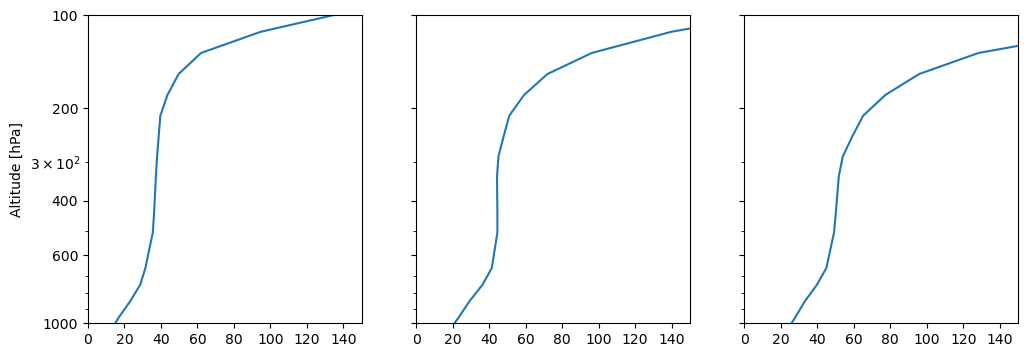

In [6]:
# c.f. Saiz-Lopez et al. 2012, ACP -- Fig. 3

gala = ozone['o3vmr'].interp(lat=1. ).mean('month')
fiji = ozone['o3vmr'].interp(lat=18.).mean('month')
naha = ozone['o3vmr'].interp(lat=26.).mean('month')

fig,axs = plt.subplots(ncols=3,sharex=True,sharey=True,figsize=(12,4))
axs[0].semilogy(gala/1e-9, ozone.plev)
axs[1].semilogy(fiji/1e-9, ozone.plev)
axs[2].semilogy(naha/1e-9, ozone.plev)

axs[0].set_ylabel('Altitude [hPa]')
for ax in axs:
    ax.set_xlabel
axs[0].set_ylim((100,1000))
axs[0].set_xlim((0,150))
axs[0].set_xticks(np.arange(0,150,20))
ylabels = [100,200,400,600,1000]
axs[0].set_yticks(ylabels)
axs[0].set_yticklabels(ylabels)
axs[0].invert_yaxis()

Text(0, 0.5, 'Pressure [hPa]')

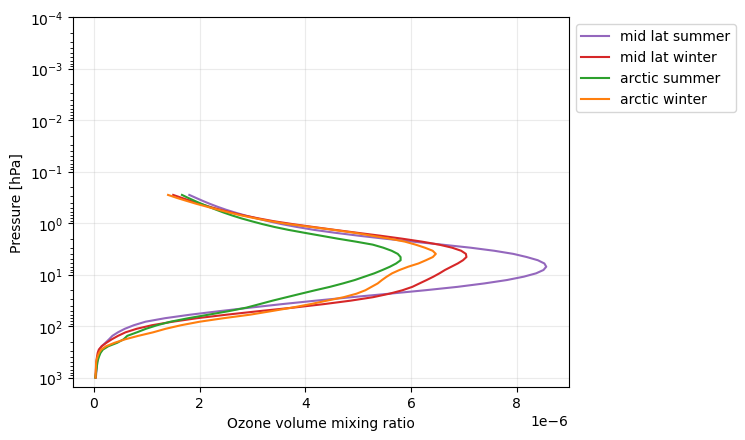

In [7]:
# c.f. Montornes et al. 2015, ACP -- Fig. 1
midlat_summer = ozone['o3vmr'].sel(lat=slice(30,60),month=[6,7,8]).mean(['lat','month'])
midlat_winter = ozone['o3vmr'].sel(lat=slice(30,60),month=[12,1,2]).mean(['lat','month'])
arctic_summer = ozone['o3vmr'].sel(lat=slice(60,90),month=[6,7,8]).mean(['lat','month'])
arctic_winter = ozone['o3vmr'].sel(lat=slice(60,90),month=[12,1,2]).mean(['lat','month'])

fig,ax = plt.subplots()
ax.semilogy(midlat_summer, ozone.plev, 'tab:purple', label='mid lat summer')
ax.semilogy(midlat_winter, ozone.plev, 'tab:red', label='mid lat winter')
ax.semilogy(arctic_summer, ozone.plev, 'tab:green', label='arctic summer')
ax.semilogy(arctic_winter, ozone.plev, 'tab:orange', label='arctic winter')
ax.invert_yaxis()
ax.set_yticks(10.**np.arange(-4,4))
ax.grid(alpha=0.25)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlabel('Ozone volume mixing ratio')
ax.set_ylabel('Pressure [hPa]')